In [97]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.physics import Physics
from pyvis.network import Network
from IPython.display import IFrame
from IPython.display import HTML
import seaborn as sns


### Comments for Prof
- As you are planning to replicate the analysis in the paper, input modelling using Toronto's data (fitting appropriate models for arrivals, trip durations and destination, etc,) is an important part of the project. Make sure to clearly explain your methods and choice of models in the final report. 
- We will discuss simulation optimization later in the course. You should be able to implement the heuristic presented in the WSC paper as well as developing your own heuristics using methods that we discuss. The idea of accounting for limited capacity for movement is interesting and could be a good extension. 
- As discussed, start with a subset of stations to build the initial model and validate it. If time permits, you can also extend it to all stations in Toronto.

# 1. Dataloading
- https://www.kaggle.com/datasets/jackywang529/toronto-bikeshare-data

In [139]:
BSD = pd.read_csv("BikeShare Data\Bike share ridership 2022-08.csv")
readme = pd.read_excel(r"BikeShare Data\bikeshare-ridership-readme.xlsx")


In [140]:
readme


,Field Name / Item / Column name,Description / Definition,Comments / Examples
0,trip_id,"Object ID, unique integer",Nominal value
1,trip_start_time,Start time and date of a trip,NaN
2,trip_stop_time,End time and date of a trip,NaN
3,trip_duration_seconds,"Duration of a trip, in seconds",NaN
4,from_station_name,Name of the station where the trip started (or...,NaN
5,to_station_name,Name of the station where the trip ended (dest...,NaN
6,user_type,The type of user that took the trip,Member (annual pass holder) or casual (24 or 7...


In [141]:
BSD

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,17515458,1174,7259,08/01/2022 00:00,Lower Spadina Ave / Lake Shore Blvd,7712.0,08/01/2022 00:20,NaN,3328,Casual Member
1,17515440,468,7208,08/01/2022 00:00,80 Clinton St (North of College),7534.0,08/01/2022 00:07,Walnut Ave / Queen St W,4662,Casual Member
2,17515442,1217,7259,08/01/2022 00:00,Lower Spadina Ave / Lake Shore Blvd,7712.0,08/01/2022 00:20,NaN,4510,Casual Member
3,17515441,1124,7269,08/01/2022 00:00,Toronto Eaton Centre (Yonge St),7076.0,08/01/2022 00:18,York St / Queens Quay W,1013,Casual Member
4,17515443,1992,7052,08/01/2022 00:00,Wellington St W / Bay St,7193.0,08/01/2022 00:33,Queen St W / Gladstone Ave,4017,Casual Member
...,...,...,...,...,...,...,...,...,...,...
705145,18317445,1670,7100,08/31/2022 23:58,Dundas St E / Regent Park Blvd,7322.0,09/01/2022 00:26,King St W / Brant St,6417,Casual Member
705146,18317447,574,7245,08/31/2022 23:58,Tecumseth St / Queen St W - SMART,7069.0,09/01/2022 00:08,Queen St W / Spadina Ave,141,Annual Member
705147,18317448,533,7257,08/31/2022 23:59,Dundas St W / St. Patrick St,7037.0,09/01/2022 00:08,Bathurst St / Dundas St W,1583,Casual Member
705148,18317449,615,7368,08/31/2022 23:59,Lisgar St / Dundas St SMART,7521.0,09/01/2022 00:09,Emerson Ave / Bloor St W,2059,Casual Member


In [142]:
# move Trip_Duration column to position 1
BSD["Trip_Duration"] = BSD.pop("Trip  Duration")
BSD.insert(1, "Trip_Duration", BSD.pop("Trip_Duration"))


In [143]:
BSD.head()

,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,17515458,1174,7259,08/01/2022 00:00,Lower Spadina Ave / Lake Shore Blvd,7712.0,08/01/2022 00:20,NaN,3328,Casual Member
1,17515440,468,7208,08/01/2022 00:00,80 Clinton St (North of College),7534.0,08/01/2022 00:07,Walnut Ave / Queen St W,4662,Casual Member
2,17515442,1217,7259,08/01/2022 00:00,Lower Spadina Ave / Lake Shore Blvd,7712.0,08/01/2022 00:20,NaN,4510,Casual Member
3,17515441,1124,7269,08/01/2022 00:00,Toronto Eaton Centre (Yonge St),7076.0,08/01/2022 00:18,York St / Queens Quay W,1013,Casual Member
4,17515443,1992,7052,08/01/2022 00:00,Wellington St W / Bay St,7193.0,08/01/2022 00:33,Queen St W / Gladstone Ave,4017,Casual Member


# 2. Data Cleaning

In [144]:
BSD["Trip_Duration"].sort_values(ascending=False)
BSD["Trip_Duration"].max()*(1/60)*(1/60)

342.4347222222222

In [145]:
# for i, row in BSD.iterrows():
#     trip_length = row["Trip_Duration"]
#     # creates a new DataFrame that includes only the rows where the trip duration is at least 2 minutes, but no more than 24 hours, and is not missing (NaN).
#     if trip_length < 120 or trip_length * (1/60) * (1/60) > 24 or math.isnan(trip_length):
#         BSD = BSD.drop(index=i)

In [146]:
BSD


,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,17515458,1174,7259,08/01/2022 00:00,Lower Spadina Ave / Lake Shore Blvd,7712.0,08/01/2022 00:20,NaN,3328,Casual Member
1,17515440,468,7208,08/01/2022 00:00,80 Clinton St (North of College),7534.0,08/01/2022 00:07,Walnut Ave / Queen St W,4662,Casual Member
2,17515442,1217,7259,08/01/2022 00:00,Lower Spadina Ave / Lake Shore Blvd,7712.0,08/01/2022 00:20,NaN,4510,Casual Member
3,17515441,1124,7269,08/01/2022 00:00,Toronto Eaton Centre (Yonge St),7076.0,08/01/2022 00:18,York St / Queens Quay W,1013,Casual Member
4,17515443,1992,7052,08/01/2022 00:00,Wellington St W / Bay St,7193.0,08/01/2022 00:33,Queen St W / Gladstone Ave,4017,Casual Member
...,...,...,...,...,...,...,...,...,...,...
705145,18317445,1670,7100,08/31/2022 23:58,Dundas St E / Regent Park Blvd,7322.0,09/01/2022 00:26,King St W / Brant St,6417,Casual Member
705146,18317447,574,7245,08/31/2022 23:58,Tecumseth St / Queen St W - SMART,7069.0,09/01/2022 00:08,Queen St W / Spadina Ave,141,Annual Member
705147,18317448,533,7257,08/31/2022 23:59,Dundas St W / St. Patrick St,7037.0,09/01/2022 00:08,Bathurst St / Dundas St W,1583,Casual Member
705148,18317449,615,7368,08/31/2022 23:59,Lisgar St / Dundas St SMART,7521.0,09/01/2022 00:09,Emerson Ave / Bloor St W,2059,Casual Member


# 3. Data Exploration

In [147]:
BSD.nunique()


Trip Id               705150
Trip_Duration           9412
Start Station Id         637
Start Time             42322
Start Station Name       597
End Station Id           638
End Time               42382
End Station Name         597
Bike Id                 6406
User Type                  2
dtype: int64

In [150]:
BSD["Trip_Duration"].describe()[1:3]


mean    1013.313234
std     3778.076613
Name: Trip_Duration, dtype: float64

In [151]:
BSD[["Start Station Name", "End Station Name", "User Type"]].describe()


,Start Station Name,End Station Name,User Type
count,672386,672375,705150
unique,597,597,2
top,York St / Queens Quay W,York St / Queens Quay W,Casual Member
freq,7247,7963,413345


## 3.1 Top 50 Routes Subset

In [152]:
# create a new DataFrame with just the start and end station names
stations = pd.DataFrame(BSD[['Start Station Name', 'End Station Name']])
# create a new DataFrame with the counts of trips between each pair of stations
counts = stations.groupby(['Start Station Name', 'End Station Name']).size().reset_index(name="NumOfTrips").sort_values(by='NumOfTrips', ascending=False)
# select the top 50 rows
top_50 = counts.head(50)
# create a DataFrame with top 50 routes
top50_routes = pd.DataFrame(top_50[['Start Station Name', 'End Station Name', 'NumOfTrips']])
top50_routes["End Station Name"].value_counts()


Humber Bay Shores Park / Marine Parade Dr        7
Lake Shore Blvd W / Ontario Dr                   5
York St / Queens Quay W                          4
Cherry Beach                                     4
HTO Park (Queens Quay W)                         3
Humber Bay Shores Park West                      3
Marilyn Bell Park Tennis Court                   3
Humber Bay Shores Park East                      3
Ontario Place Blvd / Lake Shore Blvd W (East)    3
Sunnyside - Gus Ryder Pool                       2
Tommy Thompson Park (Leslie Street Spit)         2
Queens Quay / Yonge St                           1
Queens Quay W / Lower Simcoe St                  1
Bremner Blvd / Rees St                           1
Lake Shore Blvd W / Ellis Ave                    1
Bathurst St/Queens Quay(Billy Bishop Airport)    1
Bay St / Queens Quay W (Ferry Terminal)          1
Union Station                                    1
Lake Shore Blvd W / The Boulevard Club           1
Northern Dancer Blvd / Lake Sho

In [153]:
# create a graph
G = nx.from_pandas_edgelist(top50_routes, 'Start Station Name', 'End Station Name')

# create a Pyvis network
net = Network(notebook=True, cdn_resources='remote')
net.from_nx(G)

color_map = nx.get_node_attributes(G, name="id")
neighbor_map = net.get_adj_list()

for node in net.nodes:
    # larger node: more neighbours
    node["value"] = len(neighbor_map[node["id"]])
    node["label"] = str(node['id'])

net.inherit_edge_colors(True)

# display the network
net.show('my_network.html', local=True, notebook=False)

my_network.html


In [154]:
top50_df = pd.DataFrame.merge(BSD, top50_routes)
top50_df = top50_df.drop("NumOfTrips", axis=1)
top50_df

,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,17515773,878,7175,08/01/2022 00:28,HTO Park (Queens Quay W),7175.0,08/01/2022 00:42,HTO Park (Queens Quay W),6707,Annual Member
1,17515819,5404,7175,08/01/2022 00:33,HTO Park (Queens Quay W),7175.0,08/01/2022 02:03,HTO Park (Queens Quay W),959,Casual Member
2,17515873,832,7175,08/01/2022 00:38,HTO Park (Queens Quay W),7175.0,08/01/2022 00:52,HTO Park (Queens Quay W),4225,Annual Member
3,17518743,1009,7175,08/01/2022 08:59,HTO Park (Queens Quay W),7175.0,08/01/2022 09:16,HTO Park (Queens Quay W),6476,Casual Member
4,17518744,815,7175,08/01/2022 08:59,HTO Park (Queens Quay W),7175.0,08/01/2022 09:13,HTO Park (Queens Quay W),5812,Casual Member
...,...,...,...,...,...,...,...,...,...,...
13438,18316252,666,7171,08/31/2022 22:40,Ontario Place Blvd / Lake Shore Blvd W (East),7076.0,08/31/2022 22:51,York St / Queens Quay W,2549,Annual Member
13439,18316446,1129,7171,08/31/2022 22:49,Ontario Place Blvd / Lake Shore Blvd W (East),7076.0,08/31/2022 23:07,York St / Queens Quay W,821,Casual Member
13440,18316454,1096,7171,08/31/2022 22:49,Ontario Place Blvd / Lake Shore Blvd W (East),7076.0,08/31/2022 23:07,York St / Queens Quay W,3558,Casual Member
13441,18316904,1143,7171,08/31/2022 23:14,Ontario Place Blvd / Lake Shore Blvd W (East),7076.0,08/31/2022 23:33,York St / Queens Quay W,644,Casual Member


In [156]:
top50_df["Trip_Duration"].max()

330461

In [157]:
top50_df.nunique()

Trip Id               13443
Trip_Duration          3939
Start Station Id         24
Start Time             8755
Start Station Name       24
End Station Id           22
End Time               8278
End Station Name         22
Bike Id                4534
User Type                 2
dtype: int64

In [175]:
for i, row in top50_df.iterrows():
    trip_length = row["Trip_Duration"]
    # creates a new DataFrame that includes only the rows where the trip duration is at least 2 minutes, but no more than 24 hours, and is not missing (NaN).
    if trip_length < 120 or trip_length * (1/60) * (1/60) > 8 or math.isnan(trip_length):
        top50_df = top50_df.drop(index=i)


In [176]:
top50_df

,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,17515773,878,7175,08/01/2022 00:28,HTO Park (Queens Quay W),7175.0,08/01/2022 00:42,HTO Park (Queens Quay W),6707,Annual Member
1,17515819,5404,7175,08/01/2022 00:33,HTO Park (Queens Quay W),7175.0,08/01/2022 02:03,HTO Park (Queens Quay W),959,Casual Member
2,17515873,832,7175,08/01/2022 00:38,HTO Park (Queens Quay W),7175.0,08/01/2022 00:52,HTO Park (Queens Quay W),4225,Annual Member
3,17518743,1009,7175,08/01/2022 08:59,HTO Park (Queens Quay W),7175.0,08/01/2022 09:16,HTO Park (Queens Quay W),6476,Casual Member
4,17518744,815,7175,08/01/2022 08:59,HTO Park (Queens Quay W),7175.0,08/01/2022 09:13,HTO Park (Queens Quay W),5812,Casual Member
...,...,...,...,...,...,...,...,...,...,...
13438,18316252,666,7171,08/31/2022 22:40,Ontario Place Blvd / Lake Shore Blvd W (East),7076.0,08/31/2022 22:51,York St / Queens Quay W,2549,Annual Member
13439,18316446,1129,7171,08/31/2022 22:49,Ontario Place Blvd / Lake Shore Blvd W (East),7076.0,08/31/2022 23:07,York St / Queens Quay W,821,Casual Member
13440,18316454,1096,7171,08/31/2022 22:49,Ontario Place Blvd / Lake Shore Blvd W (East),7076.0,08/31/2022 23:07,York St / Queens Quay W,3558,Casual Member
13441,18316904,1143,7171,08/31/2022 23:14,Ontario Place Blvd / Lake Shore Blvd W (East),7076.0,08/31/2022 23:33,York St / Queens Quay W,644,Casual Member


In [177]:
top50_df["Trip_Duration"].max() * (1/60) * (1/60)

7.759166666666666

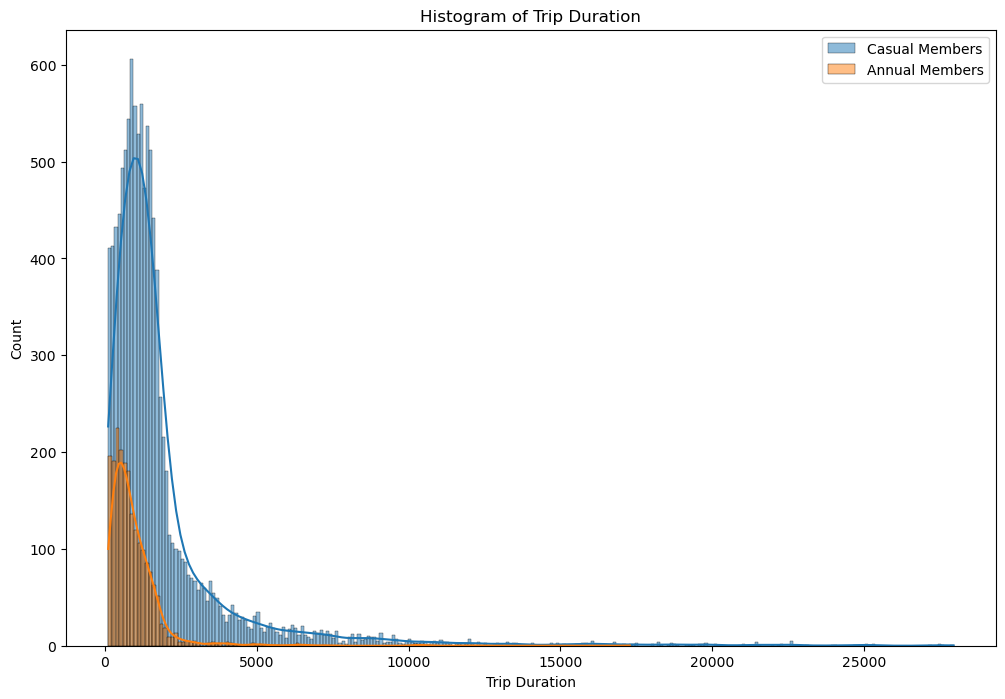

In [178]:
trip_duration_casual = top50_df[top50_df["User Type"] == 'Casual Member']
trip_duration_annual = top50_df[top50_df["User Type"] == 'Annual Member']
plt.figure(figsize=(12,8))
sns.histplot(trip_duration_casual["Trip_Duration"], kde=True, label="Casual Members")
sns.histplot(trip_duration_annual["Trip_Duration"], kde=True, label='Annual Members')
plt.xlabel("Trip Duration")
plt.title("Histogram of Trip Duration")
plt.legend()
plt.show()

# 3. Model Fitting